In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

In [14]:
df = pd.read_csv('wine-reviews.csv',usecols=['country','description','points','price','variety','winery'])
df.head()
#we will classify on the basis of description so that the model can predict the points

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [15]:
df=df.dropna(subset=['description','points'])

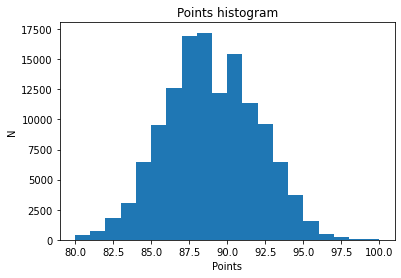

In [16]:
plt.hist(df.points, bins=20)
plt.title('Points histogram')
plt.xlabel('Points')
plt.ylabel('N')
plt.show()

In [17]:
#split up into low tier and high tier
df['label'] = (df.points>=90).astype(int)
df = df[['description','label']]
df.tail()

,description,label
129966,Notes of honeysuckle and cantaloupe sweeten th...,1
129967,Citation is given as much as a decade of bottl...,1
129968,Well-drained gravel soil gives this wine its c...,1
129969,"A dry style of Pinot Gris, this is crisp with ...",1
129970,"Big, rich and off-dry, this is powered by inte...",1


In [18]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)),int(0.9*len(df))])

In [19]:
#this function converts the samples into tf.data.Dataset object
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df["description"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [20]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

In [21]:
list(train_data)[0]

(<tf.Tensor: shape=(1024,), dtype=string, numpy=
 array([b"This light-fruited wine is the most widely available of the winery's Pinots. Its cherry and orange candy flavors give it a pleasant, albeit superficial, entry. Don't expect complexity, but for a light and accessible taste of the Willamette Valley, it's a fair value.",
        b'Aromas of cedar, allspice and black-skinned fruit take shape in the glass. On the easygoing palate, notes of ground pepper and star anise add some depth to the juicy blackberry core, while chewy tannins give it texture. Drink through 2016.',
        b'This wine is firm and structured. It also has fine black fruit and balanced acidity. Full bodied, fruity and backed by solid tannins. Drink from 2019.',
        ...,
        b"This 60% Agiorgitko/40% Syrah blend has a spicy masculine character from start to finish. On the nose, leather, spice and cherry; on the palate, leather, balsamic, rich red fruit and cherry unfold. It's not terribly complex but it's f

In [22]:
#now we will convert all the text data in the description to numeric form that the computer
#can understand via embedding
embedding = 'https://tfhub.dev/google/nnlm-en-dim50/2'
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [23]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.31413826,  0.00709982,  0.14213149, ..., -0.15211576,
        -0.31331673,  0.17984027],
       [ 0.35139444,  0.09742127, -0.13897727, ..., -0.01494882,
        -0.08205673, -0.08842428],
       [ 0.5355891 , -0.16134976,  0.03297877, ..., -0.1166499 ,
         0.15208972,  0.13086332],
       ...,
       [ 0.20391846, -0.11781898,  0.0461919 , ...,  0.00832128,
        -0.04942062,  0.0576659 ],
       [ 0.36849743, -0.331157  ,  0.07058147, ...,  0.0609594 ,
        -0.37617704, -0.07479614],
       [ 0.11590708,  0.09778243,  0.0109905 , ..., -0.05061052,
        -0.0281736 ,  0.11054791]], dtype=float32)>

In [24]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
#dropout is done to avoid overfitting because of which loss will reduce
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [25]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [26]:
model.evaluate(train_data)

102/102 [==============================] - 2s 10ms/step - loss: 0.6768 - accuracy: 0.6083


[0.6768043041229248, 0.6083134412765503]

In [27]:
model.evaluate(valid_data)

13/13 [==============================] - 0s 9ms/step - loss: 0.6774 - accuracy: 0.6079


[0.6773725152015686, 0.6079095005989075]

In [28]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 47s 452ms/step - loss: 0.6070 - accuracy: 0.6580 - val_loss: 0.4865 - val_accuracy: 0.7868
Epoch 2/5
102/102 [==============================] - 40s 394ms/step - loss: 0.4640 - accuracy: 0.7866 - val_loss: 0.4063 - val_accuracy: 0.8190
Epoch 3/5
102/102 [==============================] - 37s 360ms/step - loss: 0.4013 - accuracy: 0.8308 - val_loss: 0.3866 - val_accuracy: 0.8256
Epoch 4/5
102/102 [==============================] - 37s 366ms/step - loss: 0.3669 - accuracy: 0.8480 - val_loss: 0.3804 - val_accuracy: 0.8301
Epoch 5/5
102/102 [==============================] - 37s 360ms/step - loss: 0.3396 - accuracy: 0.8618 - val_loss: 0.3828 - val_accuracy: 0.8308


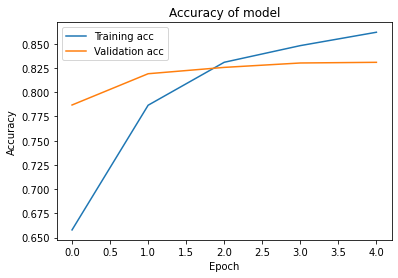

In [31]:

plt.plot(history.history['accuracy'], label='Training acc')
plt.plot(history.history['val_accuracy'], label='Validation acc')
plt.title('Accuracy of model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

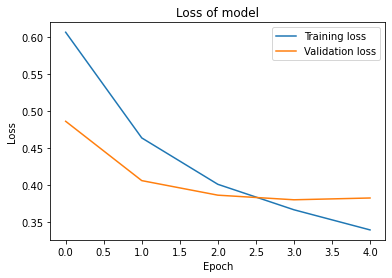

In [32]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss of model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [33]:
model.evaluate(test_data)

13/13 [==============================] - 1s 41ms/step - loss: 0.3824 - accuracy: 0.8307


[0.38235387206077576, 0.8306662440299988]